In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preparation

In [3]:
X_train_trf1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_train_trf1_v3.csv')
X_val_trf1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_val_trf1_v3.csv')
X_test_trf1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_test_trf1_v3.csv')

#Drop rating_month and rating_year columns
#Drop primaryTitle, userId_ori, movieId_ori

X_test_complete = X_test_trf1.loc[:,['primaryTitle', 'userId','userId_ori']]

def dropRatingDate(df):
  cols = [0, 1, 2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 42]
  return df.drop(df.columns[cols], axis=1)

X_train_trf1 = dropRatingDate(X_train_trf1)
X_test_trf1 = dropRatingDate(X_test_trf1)
X_val_trf1 = dropRatingDate(X_val_trf1)

columns_list = X_train_trf1.columns.tolist()

X_train_trf1 = X_train_trf1.to_numpy()
X_val_trf1 = X_val_trf1.to_numpy()
X_test_trf1 = X_test_trf1.to_numpy() 

y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_train_xg_v3.csv').to_numpy(dtype = 'int')
y_val= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_val_xg_v3.csv').to_numpy(dtype = 'int')
y_test= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_test_xg_v3.csv').to_numpy(dtype = 'int')

In [4]:
#Convert 9bins to 2bins
def nineToTwoBins(y_dataset):
    for i in range(0, len(y_dataset)): 
        if y_dataset[i] < 7:
            y_dataset[i] = 0
        else:
            y_dataset[i] = 1
    return y_dataset

In [5]:
nineToTwoBins(y_train)
nineToTwoBins(y_val)
nineToTwoBins(y_test)

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [6]:
training_data = {'X_train':X_train_trf1,'Y_train':y_train,
                'X_val': X_val_trf1,'Y_val':y_val,
                'X_test': X_test_trf1 ,'Y_test':y_test}

# XGBoost Model

In [10]:
#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data,epochs=50):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0]))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Precision: '+str(precision_score(sk_model.predict(training_data['X_val']), training_data['Y_val'])))
    print('XGBoost Recall: '+str(recall_score(sk_model.predict(training_data['X_val']),training_data['Y_val'])))
    print('XGBoost ROC_AUC: '+str(roc_auc_score(training_data['Y_val'],sk_model.predict_proba(training_data['X_val'])[:,1])))
    plot_compare(metrics,store,epochs)
    features = columns_list
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()
    
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

Fitting model...
Fitting done!
[0]	val-mlogloss:0.662365	val-merror:0.30811	train-mlogloss:0.662447	train-merror:0.308269
[49]	val-mlogloss:0.55798	val-merror:0.278705	train-mlogloss:0.557583	train-merror:0.27955
-- Model Report --
XGBoost Precision: 0.38574166347259486
XGBoost Recall: 0.7043673012318029
XGBoost ROC_AUC: 0.6551592397071567


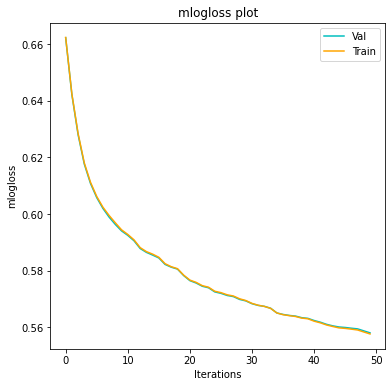

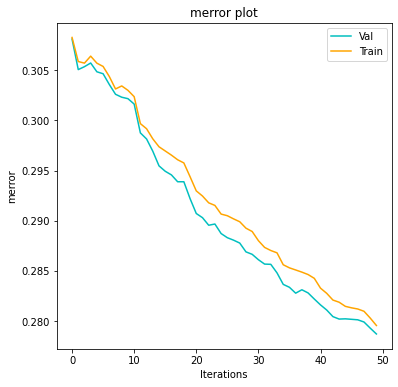

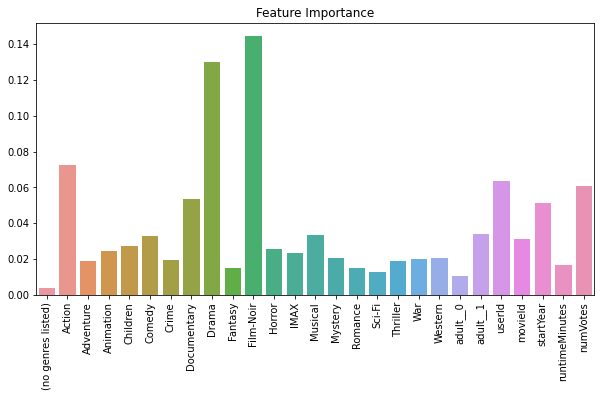

In [11]:
xgb1 = XGBClassifier(learning_rate=0.2,
                    n_estimators=300,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    tree_method = "gpu_hist",
                    objective='multi:softmax',
                    num_class=2,
                    seed=27)


fitXgb(xgb1, training_data)

# GridSearch Parameter Test

In [12]:
#GridSearch Param Test Max_Depth and min_child_weight

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train_trf1, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=300, n_jobs=1,
                                     nthread=None, num_class=2,
                                     objective='multi:softmax', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
             

In [ ]:
getTrainScores(gsearch1)

In [ ]:
%%time
xgb2 = XGBClassifier(learning_rate=0.2,
                    n_estimators=300,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    tree_method = "gpu_hist",
                    objective='multi:softmax',
                    num_class=2,
                    seed=27)


fitXgb(xgb2, training_data)

In [ ]:
#Test subsample and colsample_bytree

param_test2 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train_trf1, y_train)

In [ ]:
getTrainScores(gsearch2)

In [ ]:
%%time
xgb3 = XGBClassifier(learning_rate=0.2,
                    n_estimators=300,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.6,
                    tree_method = "gpu_hist",
                    objective='multi:softmax',
                    num_class=2,
                    seed=27)


fitXgb(xgb3, training_data)

In [ ]:
#Test reg_alpha

param_test3 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch2 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train_trf1, y_train)

In [ ]:
getTrainScores(gsearch2)

Reduce learning rate and increase number of estimators

Fitting model...
Fitting done!
[0]	val-mlogloss:0.673671	val-merror:0.288767	train-mlogloss:0.673354	train-merror:0.284997
[29]	val-mlogloss:0.52551	val-merror:0.256121	train-mlogloss:0.51459	train-merror:0.248346
-- Model Report --
XGBoost Precision: 0.5963204292832502
XGBoost Recall: 0.72416682182089
XGBoost ROC_AUC: 0.7452532794227122


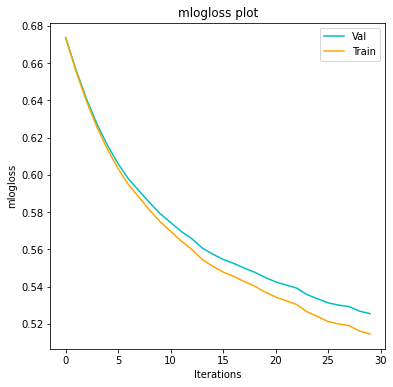

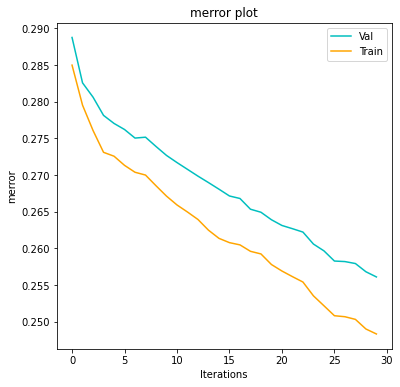

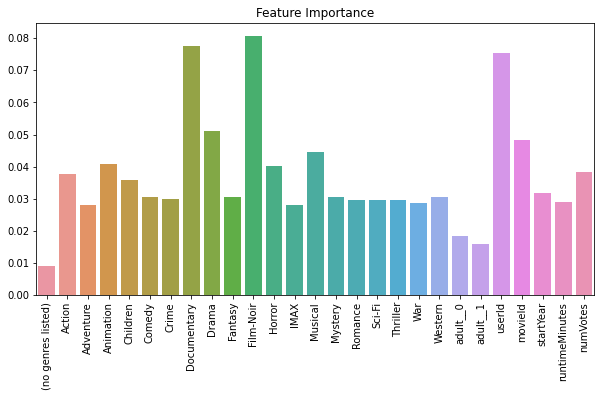

CPU times: user 1min 25s, sys: 49.7 s, total: 2min 15s
Wall time: 2min 15s


In [8]:
%%time
xgb4 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.6,
                    reg_alpha = 0.01,
                    tree_method = "gpu_hist",
                    objective='multi:softmax',
                    num_class=2,
                    seed=27)


fitXgb(xgb4, training_data)

# Output Dataframe

In [ ]:
X_test_complete

In [ ]:
predictions = xgb4.predict(X_test_trf1)

X_test_complete['prediction'] = predictions

X_test_complete = X_test_complete[X_test_complete.prediction != 0]

In [ ]:
X_test_complete